In [1]:
import cv2
import time
import numpy as np
import torch
import random
from torch import Tensor
import json
import os
from os import listdir
from os.path import isfile, join
from torch.nn import BCEWithLogitsLoss
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as xfms
from pathlib import Path
from tqdm import tqdm
from PIL import Image
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

In [4]:
torch.cuda.is_available()

True

## Create Dataset

In [5]:
class CCAgT_Dataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        初始化數據集。
        :param image_dir: 圖片目錄
        :param mask_dir: 標籤目錄
        :param transform: 用於圖片和標籤的數據增強方法
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # 獲取所有類別的子文件夾
        self.categories = os.listdir(image_dir)

        # 生成所有圖像和標籤的路徑
        self.image_paths = []
        self.mask_paths = []
        for category in self.categories:
            category_image_dir = os.path.join(image_dir, category)
            category_mask_dir = os.path.join(mask_dir, category)
            if not os.path.isdir(category_image_dir):
                continue

            images = os.listdir(category_image_dir)
            for img_name in images:
                self.image_paths.append(
                    os.path.join(category_image_dir, img_name))
                self.mask_paths.append(os.path.join(
                    category_mask_dir, img_name.replace('.jpg', '.png')))  # 假設 mask 命名規則一致

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = Image.open(image_path).convert("RGB")  # 載入 RGB 圖片
        mask = Image.open(mask_path).convert("L")  # 載入灰階標籤

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [6]:
img_size = [256, 256]
LR = 1e-4
BATCH = 24
EPOCHS = 30
image_dir = './size_512/images_crop'
mask_dir = './size_512/masks_crop'

transform = transforms.Compose([transforms.Resize(img_size),
                                transforms.ToTensor()]
                               )
test_transform = transforms.ToTensor()
dataset = CCAgT_Dataset(image_dir, mask_dir, transform=transform)

# 劃分數據集
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size])

In [7]:
from torch.utils.data import DataLoader

# 創建 DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
a = next(iter(train_loader))
print(len(a[0]))

16


In [9]:
def contours_generate(input_img, fusion_img):
    input_img = np.float32(input_img)
    img_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    img_gray *= 255
    colors = [(255, 50, 0), (131, 60, 11), (0, 255, 0),
              (0, 0, 255), (255, 0, 255), (255, 0, 0), (0, 0, 128)]
    for threshhold in range(1, 8):
        ret, thresh = cv2.threshold(
            np.uint8(img_gray), (threshhold*36-1), 255, cv2.THRESH_BINARY)
        _, contours, hierarchy = cv2.findContours(
            thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            if threshhold == 1:
                hull = cv2.drawContours(
                    fusion_img, contours, -1, colors[threshhold-2], 6)
            else:
                hull = cv2.drawContours(
                    hull, contours, -1, colors[threshhold-2], 6)
        else:
            hull = fusion_img
    return hull


def vs_generate(input_mask, gen_mask, fusion):
    err_space = np.float64(np.logical_xor(input_mask, gen_mask))
    corr_space = np.logical_and(input_mask, gen_mask)
    R, G, B = cv2.split(err_space)
    R[R == 0] = 0.18
    G[G == 0] = 0.46
    G[G > 0.47] = 0
    B[B == 0] = 0.71
    B[B > 0.72] = 0
    err_space = cv2.merge([R, G, B])

    err_space *= np.float64(np.logical_not(corr_space))
    corr_space = np.float64(corr_space)
    corr_space *= fusion
    err_space += corr_space
    return err_space


def compress_channel(input_batch_img, threshold):
    single_img = torch.zeros(
        1, input_batch_img.size(2), input_batch_img.size(3))
    output_batch_img = torch.zeros(input_batch_img.size(0), 1,
                                   input_batch_img.size(2), input_batch_img.size(3))
    for idx, n in enumerate(input_batch_img):
        for ch, img in enumerate(n):
            single_img[0][img > threshold] = ch
        output_batch_img[idx] = single_img
    return output_batch_img


def show_images(input_imgs, input_masks: None, gen_masks=None,
                nrow=5, ncol=1, show: bool = True, save: bool = False, path="", mode: bool = False):
    # compare and show n*m images from generator in one figure and optionally save it
    if input_imgs.shape[0] < nrow:
        nrow = input_imgs.shape[0]
    figsize = (nrow*3+2, 9)
    count = 311
    img_label = ["input\nimages", "input\nmask"]
    inputs = [input_imgs, input_masks]
    offset = -0.1

    if mode == True and gen_masks == None:
        print("Input ERROR! Expected [gen_mask] but got [None].")
        return None

    elif mode == True and gen_masks != None:
        figsize = (nrow*3+2, 18)
        count = 611
        img_label.append("generated\nmask")
        inputs.append(gen_masks)

    plt.figure(figsize=figsize)
    for imgs, label in zip([imgs for imgs in inputs if input_masks is not None], img_label):
        print(imgs.size())
        imgs = imgs[:nrow * ncol]
        imgs = imgs.view(imgs.size(0), imgs.size(1), 256, 256)
        ax = plt.subplot(count)
        ax.set_title(label, x=offset, y=0.35)
        img = np.transpose(
            make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0))
        img = np.float32(np.array(img))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(
            img, (img.shape[1]*2, int(img.shape[0]*1.5)), interpolation=cv2.INTER_AREA)
        plt.axis("off")
        plt.imshow(img)

        if label == "input\nmask":
            input_mask = img
        if label == "generated\nmask":
            gen_mask = img

        if label == "input\nimages":
            origin_img = img/3+0.6
        else:
            count += 1
            ax = plt.subplot(count)
            name = label.split("\n")[0] + "\nfusion"
            ax.set_title(name, x=offset, y=0.35)
            fusion = origin_img.copy()
            contours_generate(img, fusion)
            plt.axis("off")
            plt.imshow(fusion)

        if label == "generated\nmask":
            count += 1
            ax = plt.subplot(count)
            name = "ground truth\nvs\ngenerated"
            ax.set_title(name, x=offset, y=0.35)
            fusion = origin_img.copy()
            vs = vs_generate(input_mask, gen_mask, fusion)
            # print(vs,)
            plt.axis("off")
            plt.imshow(vs)
        count += 1
    if save:
        plt.savefig('./show.png')
    if show:
        plt.show()

In [10]:
import cv2
print(cv2.__version__)

3.4.18


torch.Size([16, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


torch.Size([16, 1, 256, 256])


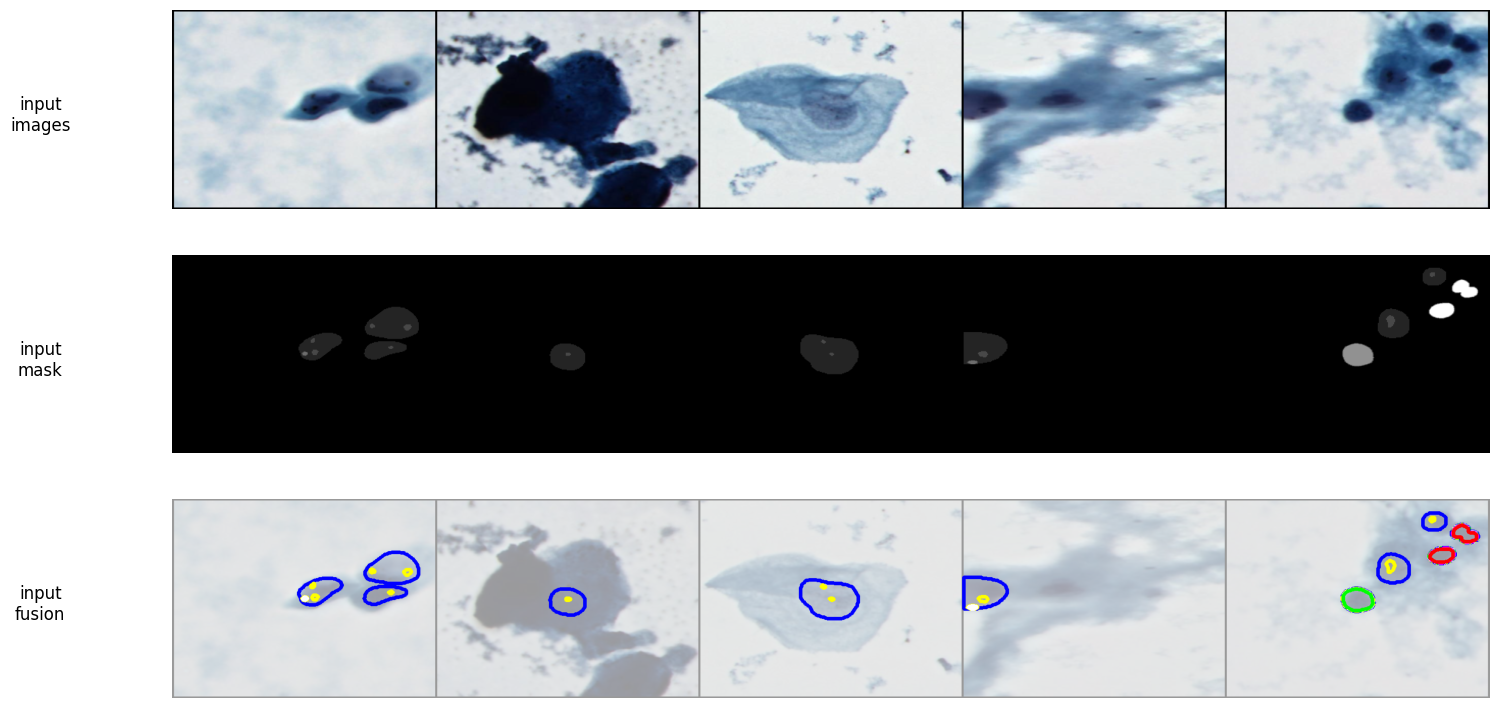

In [11]:
show_images(a[0], a[1].float(), mode=False)

Unique values in mask: [0.         0.00392157 0.00784314 0.01176471 0.01568628]


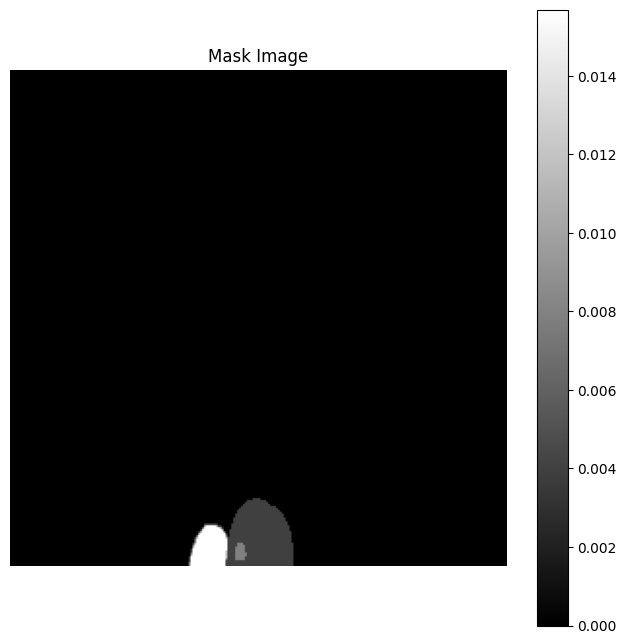

In [12]:
import matplotlib.pyplot as plt


def show_mask_image(mask):
    """
    顯示並打印出單個 mask image 的內容。
    :param mask: numpy array 或 tensor，表示 mask image
    """
    if isinstance(mask, torch.Tensor):  # 如果是 PyTorch tensor，轉換為 numpy
        mask = mask.numpy()

    # 確保 mask 是 2D 的
    if len(mask.shape) == 3 and mask.shape[0] == 1:  # (1, H, W)
        mask = mask.squeeze(0)
    elif len(mask.shape) == 3 and mask.shape[-1] == 1:  # (H, W, 1)
        mask = mask.squeeze(-1)

    # 打印 mask 數值
    unique_values = np.unique(mask)
    print("Unique values in mask:", unique_values)
    # mask = (mask * 255).astype(np.uint8)

    # 顯示 mask
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap="gray")
    plt.colorbar()
    plt.title("Mask Image")
    plt.axis("off")
    plt.show()


# 假設使用 PyTorch DataLoader 獲取數據
for images, masks in train_loader:
    # 選擇第一個 mask
    mask = masks[0]  # shape: (1, H, W)
    show_mask_image(mask)
    break

## Training

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """兩個卷積層組成的基本單元，包含卷積 + 批量正則化 + 激活函數"""

    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Encoder（下採樣）
        self.enc1 = DoubleConv(n_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.enc4 = DoubleConv(256, 512)

        # 中間層
        self.bottleneck = DoubleConv(512, 1024)

        # Decoder（上採樣）
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)  # 512 + 512 (跳躍連接)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)  # 256 + 256 (跳躍連接)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)  # 128 + 128 (跳躍連接)

        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)  # 64 + 64 (跳躍連接)

        # 輸出層
        self.out_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        # Encoder 路徑
        x1 = self.enc1(x)  # [B, 64, H, W]
        x2 = self.enc2(F.max_pool2d(x1, kernel_size=2))  # [B, 128, H/2, W/2]
        x3 = self.enc3(F.max_pool2d(x2, kernel_size=2))  # [B, 256, H/4, W/4]
        x4 = self.enc4(F.max_pool2d(x3, kernel_size=2))  # [B, 512, H/8, W/8]

        # 中間層
        x_bottleneck = self.bottleneck(F.max_pool2d(
            x4, kernel_size=2))  # [B, 1024, H/16, W/16]

        # Decoder 路徑
        x = self.up1(x_bottleneck)  # 上採樣 [B, 512, H/8, W/8]
        x = self.dec1(torch.cat([x, x4], dim=1))  # 跳躍連接 + 解碼

        x = self.up2(x)  # 上採樣 [B, 256, H/4, W/4]
        x = self.dec2(torch.cat([x, x3], dim=1))

        x = self.up3(x)  # 上採樣 [B, 128, H/2, W/2]
        x = self.dec3(torch.cat([x, x2], dim=1))

        x = self.up4(x)  # 上採樣 [B, 64, H, W]
        x = self.dec4(torch.cat([x, x1], dim=1))

        # 輸出層
        output = self.out_conv(x)  # [B, n_classes, H, W]
        return output

In [14]:
class CustomScheduler:
    def __init__(self, optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6, verbose=False):
        """
        自定義學習率調度器
        :param optimizer: 優化器
        :param mode: 減少依據 ("min" 或 "max")
        :param factor: 每次減少學習率的比例
        :param patience: 容忍驗證損失不改善的 epoch 數
        :param min_lr: 學習率的下限
        :param verbose: 是否打印學習率變化信息
        """
        self.optimizer = optimizer
        self.mode = mode
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr
        self.verbose = verbose

        self.best_score = None
        self.num_bad_epochs = 0
        self.lr_reduced = False

    def step(self, metric):
        """
        更新學習率
        :param metric: 監控的指標（如驗證損失或準確率）
        """
        # 初始化最佳分數
        if self.best_score is None:
            self.best_score = metric
            return

        # 判斷是否改善
        is_improved = (metric < self.best_score) if self.mode == 'min' else (
            metric > self.best_score)

        if is_improved:
            self.best_score = metric
            self.num_bad_epochs = 0
            self.lr_reduced = False
        else:
            self.num_bad_epochs += 1

        # 當超過 patience 時降低學習率
        if self.num_bad_epochs > self.patience and not self.lr_reduced:
            self._reduce_lr()

    def _reduce_lr(self):
        """
        減少學習率
        """
        for param_group in self.optimizer.param_groups:
            new_lr = max(param_group['lr'] * self.factor, self.min_lr)
            if param_group['lr'] > self.min_lr:
                param_group['lr'] = new_lr
                self.lr_reduced = True
                if self.verbose:
                    print(f"Learning rate reduced to {new_lr:.6f}")

In [15]:
unet = UNet(n_channels=3, n_classes=8).to(device)
optimizer = optim.Adam(unet.parameters(), lr=LR)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)
criterion = nn.CrossEntropyLoss(ignore_index=8)
scheduler = CustomScheduler(optimizer, mode='min',
                            factor=0.5, patience=3, min_lr=1e-6, verbose=True)

/tmp/ipykernel_515838/154102060.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler(enabled=False)


In [16]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# 初始化變數
train_loss = []
val_loss = []
best_val_loss = float('inf')  # 最佳驗證損失
checkpoint_path = "best_model.pth"  # 檢查點路徑

for epoch in range(EPOCHS):
    # 訓練模式
    unet.train()
    epoch_train_loss = 0
    i_bar = tqdm(train_loader, unit='iter', desc=f'Epoch {epoch + 1}')

    for imgs, masks in i_bar:
        imgs, masks = imgs.to(device), masks.to(device)  # 移動到 GPU 或 CPU
        optimizer.zero_grad()  # 清除上一輪梯度

        # 前向傳播
        preds = unet(imgs)
        preds = preds.float()

        # 計算損失
        masks = (masks * 255).long()  # 將 [0, 1] 範圍的浮點數轉換為 [0, 7] 的整數
        masks = masks.squeeze(1)  # 變為 [Batch, Height, Width]
        # 將 logits 轉換為類別索引
        preds_classes = torch.argmax(preds, dim=1)  # [Batch, Height, Width]

        # 打印類別索引的唯一值
        # print("Unique Preds values:", preds_classes.unique())
        # print("Unique mask values:", masks.unique())  # 應該是 [0, 1, ..., 7]
        loss = criterion(preds, masks)
        epoch_train_loss += loss.item()

        # 反向傳播與梯度更新
        loss.backward()
        optimizer.step()

        i_bar.set_postfix(loss=loss.item())  # 更新進度條顯示

    train_loss.append(epoch_train_loss / len(train_loader))  # 儲存訓練損失

    # 驗證模式
    unet.eval()
    epoch_val_loss = 0

    with torch.no_grad():  # 不計算梯度
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)  # 移動到 GPU 或 CPU

            # 前向傳播
            preds = unet(imgs)
            preds = preds.float()
            masks = (masks * 255).long()  # 將 [0, 1] 範圍的浮點數轉換為 [0, 7] 的整數
            masks = masks.squeeze(1)  # 變為 [Batch, Height, Width]
            loss = criterion(preds, masks)
            epoch_val_loss += loss.item()

    val_loss.append(epoch_val_loss / len(val_loader))  # 儲存驗證損失

    # 保存最好的驗證模型權重
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        torch.save(unet.state_dict(), checkpoint_path)
        print(f"Saved best model with validation loss: {best_val_loss:.4f}")

    # 更新學習率
    scheduler.step(val_loss[-1])

    # 打印訓練與驗證損失
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"Train Loss: {train_loss[-1]:.4f}")
    print(f"Validation Loss: {val_loss[-1]:.4f}")
    print("----------------------------------------------")

Epoch 1: 100%|██████████| 918/918 [04:06<00:00,  3.72iter/s, loss=0.209]


Saved best model with validation loss: 0.2216
Epoch 1/30
Train Loss: 0.6302
Validation Loss: 0.2216
----------------------------------------------


Epoch 2: 100%|██████████| 918/918 [04:07<00:00,  3.71iter/s, loss=0.138] 


Saved best model with validation loss: 0.0975
Epoch 2/30
Train Loss: 0.1375
Validation Loss: 0.0975
----------------------------------------------


Epoch 3: 100%|██████████| 918/918 [04:07<00:00,  3.71iter/s, loss=0.0738]


Saved best model with validation loss: 0.0785
Epoch 3/30
Train Loss: 0.0919
Validation Loss: 0.0785
----------------------------------------------


Epoch 4: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0615]


Saved best model with validation loss: 0.0717
Epoch 4/30
Train Loss: 0.0787
Validation Loss: 0.0717
----------------------------------------------


Epoch 5: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0377]


Saved best model with validation loss: 0.0667
Epoch 5/30
Train Loss: 0.0719
Validation Loss: 0.0667
----------------------------------------------


Epoch 6: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0988]


Epoch 6/30
Train Loss: 0.0667
Validation Loss: 0.0682
----------------------------------------------


Epoch 7: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.133] 


Saved best model with validation loss: 0.0633
Epoch 7/30
Train Loss: 0.0628
Validation Loss: 0.0633
----------------------------------------------


Epoch 8: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.123] 


Epoch 8/30
Train Loss: 0.0584
Validation Loss: 0.0645
----------------------------------------------


Epoch 9: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0475]


Epoch 9/30
Train Loss: 0.0537
Validation Loss: 0.0640
----------------------------------------------


Epoch 10: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.039] 


Saved best model with validation loss: 0.0586
Epoch 10/30
Train Loss: 0.0491
Validation Loss: 0.0586
----------------------------------------------


Epoch 11: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0672]


Epoch 11/30
Train Loss: 0.0453
Validation Loss: 0.0595
----------------------------------------------


Epoch 12: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0447]


Saved best model with validation loss: 0.0567
Epoch 12/30
Train Loss: 0.0406
Validation Loss: 0.0567
----------------------------------------------


Epoch 13: 100%|██████████| 918/918 [04:21<00:00,  3.52iter/s, loss=0.0387]


Epoch 13/30
Train Loss: 0.0374
Validation Loss: 0.0597
----------------------------------------------


Epoch 14: 100%|██████████| 918/918 [05:33<00:00,  2.76iter/s, loss=0.0425]


Epoch 14/30
Train Loss: 0.0340
Validation Loss: 0.0636
----------------------------------------------


Epoch 15: 100%|██████████| 918/918 [04:26<00:00,  3.45iter/s, loss=0.024] 


Epoch 15/30
Train Loss: 0.0319
Validation Loss: 0.0607
----------------------------------------------


Epoch 16: 100%|██████████| 918/918 [04:20<00:00,  3.53iter/s, loss=0.0343]


Learning rate reduced to 0.000050
Epoch 16/30
Train Loss: 0.0293
Validation Loss: 0.0621
----------------------------------------------


Epoch 17: 100%|██████████| 918/918 [04:14<00:00,  3.61iter/s, loss=0.0232]


Epoch 17/30
Train Loss: 0.0230
Validation Loss: 0.0593
----------------------------------------------


Epoch 18: 100%|██████████| 918/918 [04:09<00:00,  3.67iter/s, loss=0.0147] 


Epoch 18/30
Train Loss: 0.0210
Validation Loss: 0.0644
----------------------------------------------


Epoch 19: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0152] 


Epoch 19/30
Train Loss: 0.0202
Validation Loss: 0.0633
----------------------------------------------


Epoch 20: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0165] 


Epoch 20/30
Train Loss: 0.0194
Validation Loss: 0.0692
----------------------------------------------


Epoch 21: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0142] 


Epoch 21/30
Train Loss: 0.0186
Validation Loss: 0.0678
----------------------------------------------


Epoch 22: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0201] 


Epoch 22/30
Train Loss: 0.0185
Validation Loss: 0.0639
----------------------------------------------


Epoch 23: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0139] 


Epoch 23/30
Train Loss: 0.0175
Validation Loss: 0.0651
----------------------------------------------


Epoch 24: 100%|██████████| 918/918 [04:07<00:00,  3.70iter/s, loss=0.0164] 


Epoch 24/30
Train Loss: 0.0170
Validation Loss: 0.0678
----------------------------------------------


Epoch 25: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0146] 


Epoch 25/30
Train Loss: 0.0169
Validation Loss: 0.0714
----------------------------------------------


Epoch 26: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0176] 


Epoch 26/30
Train Loss: 0.0164
Validation Loss: 0.0712
----------------------------------------------


Epoch 27: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.0119] 


Epoch 27/30
Train Loss: 0.0164
Validation Loss: 0.0731
----------------------------------------------


Epoch 28: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0203] 


Epoch 28/30
Train Loss: 0.0160
Validation Loss: 0.0699
----------------------------------------------


Epoch 29: 100%|██████████| 918/918 [04:08<00:00,  3.69iter/s, loss=0.0186] 


Epoch 29/30
Train Loss: 0.0154
Validation Loss: 0.0767
----------------------------------------------


Epoch 30: 100%|██████████| 918/918 [04:08<00:00,  3.70iter/s, loss=0.00956]


Epoch 30/30
Train Loss: 0.0156
Validation Loss: 0.0803
----------------------------------------------


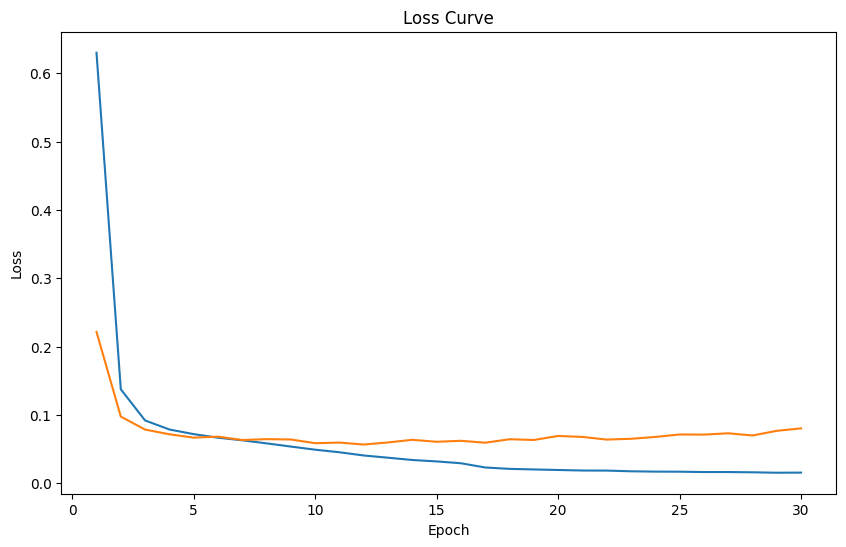

In [17]:
# 繪製損失曲線
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss")
plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

In [27]:
import numpy as np
import torch


def calculate_metrics(preds, targets, num_classes):
    """
    計算語義分割的多種評估指標。
    :param preds: 模型的預測，形狀為 [Batch, Height, Width]（類別索引）。
    :param targets: 真實標籤，形狀為 [Batch, Height, Width]（類別索引）。
    :param num_classes: 總類別數。
    :return: 各指標的字典。
    """
    metrics = {
        'Pixel Accuracy': 0,  # 總體像素準確率
        'class Pixel Accuracy': [],  # 每類別像素準確率 (cPA)
        'mean Pixel Accuracy': 0,  # 平均像素準確率 (mPA)
        'Dice coefficient': [],  # Dice 指數
        'IoU': [],  # 每類別 IoU
        'mean IoU': 0,  # 平均 IoU
        'mAP@[.5:.95:.05]': 0  # mean Average Precision (mAP)
    }

    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    # 初始化混淆矩陣
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    # 計算混淆矩陣
    for pred, target in zip(preds, targets):
        for i in range(num_classes):
            for j in range(num_classes):
                confusion_matrix[i, j] += np.sum((pred == i) & (target == j))

    # 計算 Pixel Accuracy (PA)
    metrics['Pixel Accuracy'] = np.trace(
        confusion_matrix) / np.sum(confusion_matrix)

    # 計算每類別的指標
    for i in range(num_classes):
        TP = confusion_matrix[i, i]
        FP = np.sum(confusion_matrix[i, :]) - TP
        FN = np.sum(confusion_matrix[:, i]) - TP
        TN = np.sum(confusion_matrix) - (TP + FP + FN)

        # class Pixel Accuracy (cPA)
        if (TP + FP) > 0:
            cPA = TP / (TP + FP)
            metrics['class Pixel Accuracy'].append(cPA)
        else:
            metrics['class Pixel Accuracy'].append(0)

        # Dice coefficient
        dice = (2 * TP) / (2 * TP + FP + FN + 1e-6)
        metrics['Dice coefficient'].append(dice)

        # IoU
        iou = TP / (TP + FP + FN + 1e-6)
        metrics['IoU'].append(iou)

    # mean Pixel Accuracy (mPA)
    metrics['mean Pixel Accuracy'] = np.mean(
        metrics['class Pixel Accuracy'])

    # mean IoU
    metrics['mean IoU'] = np.mean(metrics['IoU'])

    # mAP@[.5:.95:.05]
    # 對於 mAP 的簡單實現，假設每類別 AP 為 IoU 的平均值（更復雜實現需考慮檢測框）
    metrics['mAP@[.5:.95:.05]'] = np.mean(metrics['IoU'])

    return metrics

In [28]:
all_metrics = {
    'Pixel Accuracy': [],
    'class Pixel Accuracy': [],
    'mean Pixel Accuracy': [],
    'Dice coefficient': [],
    'IoU': [],
    'mean IoU': [],
    'mAP@[.5:.95:.05]': []
}

/tmp/ipykernel_515838/2158463516.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(checkpoint_path))
Clipping input data to the valid range

torch.Size([10, 3, 256, 256])
torch.Size([10, 1, 1, 256, 256])
torch.Size([10, 1, 256, 256])


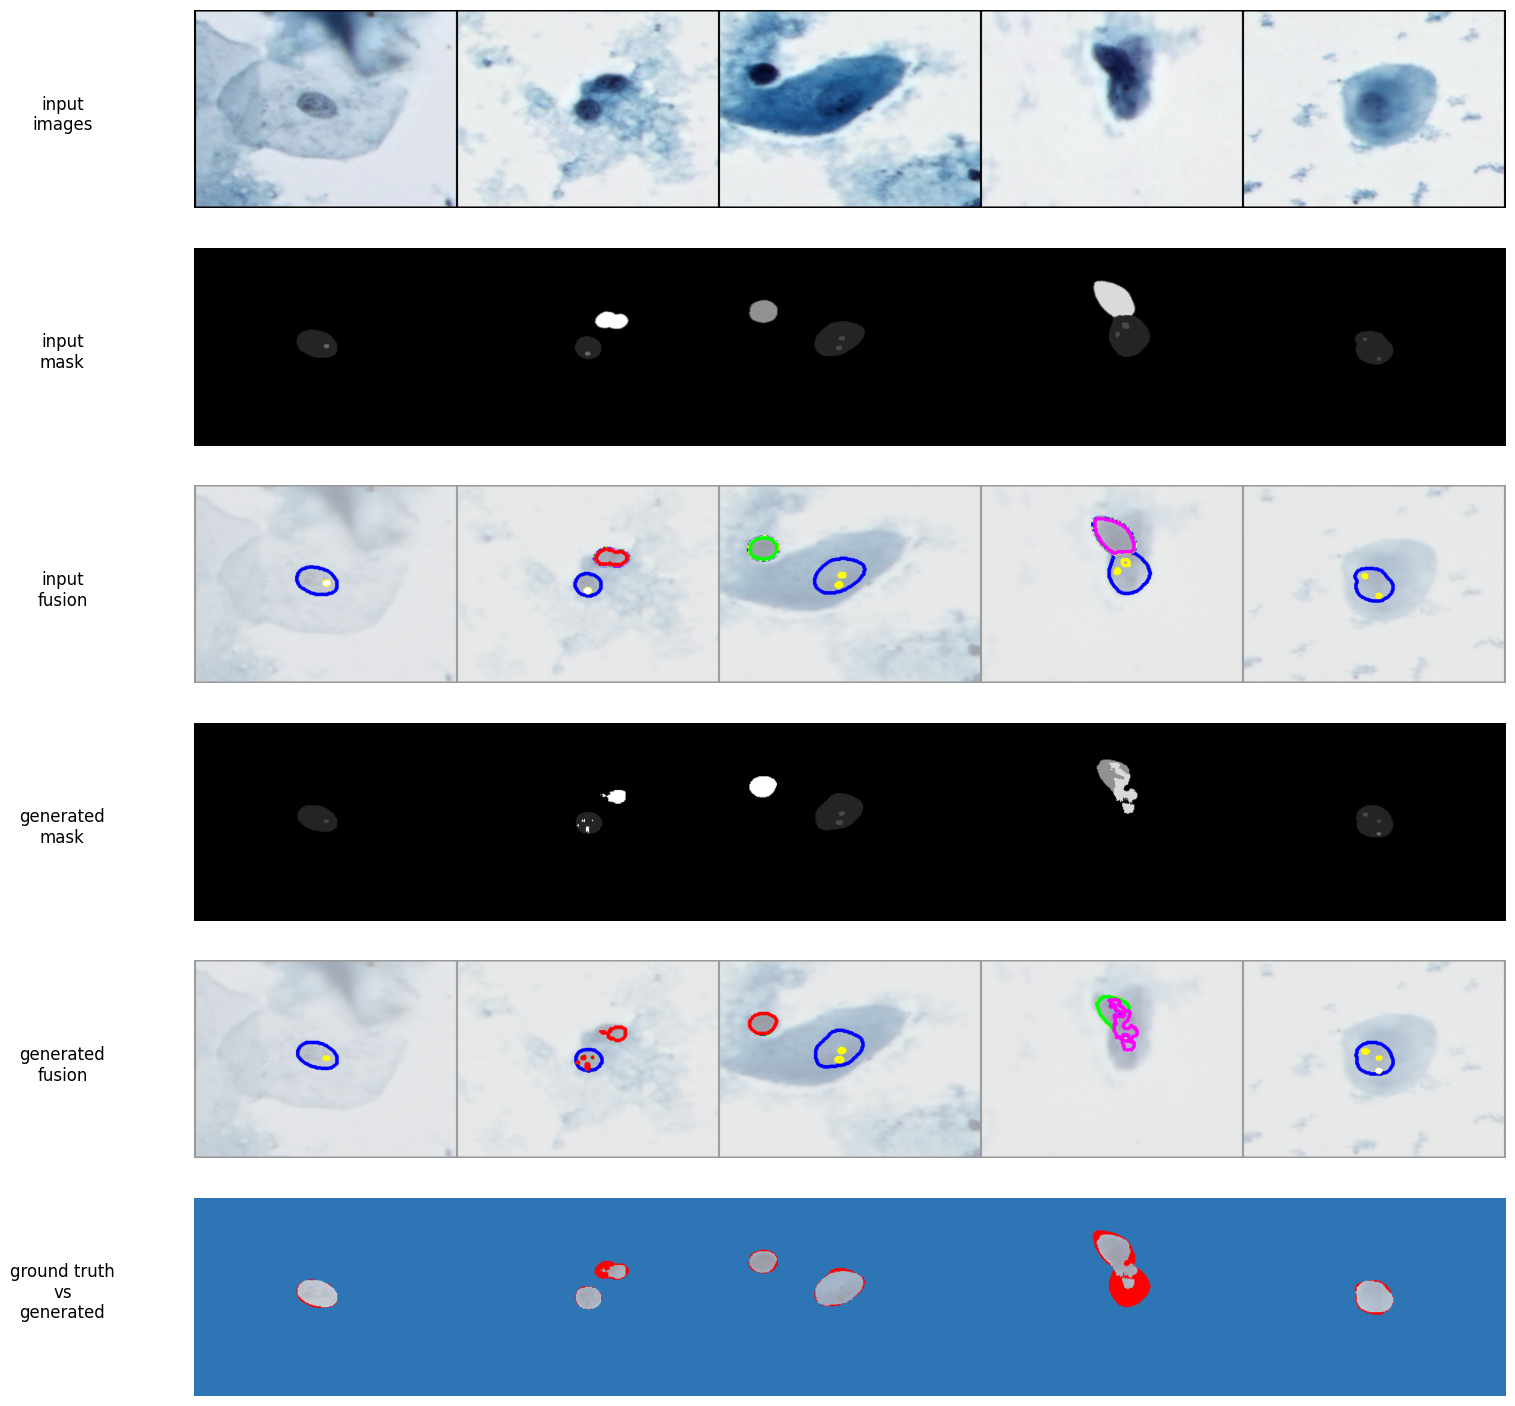

In [32]:
import numpy as np

# 加載最好的模型權重
checkpoint_path = "best_model.pth"
unet.load_state_dict(torch.load(checkpoint_path))
unet.eval()  # 設置為評估模式

# 初始化存儲結果的列表
results = []  # 存儲每個樣本的 (imgs, masks, masks_pred, score)

# 測試過程
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        masks_pred = unet(imgs)

        # 壓縮為類別索引
        masks_pred = torch.argmax(masks_pred, dim=1)

       # 計算指標
        batch_metrics = calculate_metrics(masks_pred, masks, num_classes=8)

        # 使用 mean Dice coefficient 作為選擇標準
        avg_score = np.mean([
            np.mean(batch_metrics['IoU']),
            np.mean(batch_metrics['Dice coefficient']),
            batch_metrics['Pixel Accuracy']
        ])
        # 儲存結果
        for i in range(imgs.size(0)):
            results.append({
                "imgs": imgs[i].cpu(),
                "masks": masks[i].cpu(),
                "masks_pred": masks_pred[i].cpu(),
                "scores": {
                    "PA": batch_metrics['Pixel Accuracy'],
                    "cPA": batch_metrics['class Pixel Accuracy'],
                    "mPA": batch_metrics['mean Pixel Accuracy'],
                    "Dice": np.mean(batch_metrics['Dice coefficient']),
                    "IoU": np.mean(batch_metrics['IoU']),
                    "mIoU": batch_metrics['mean IoU'],
                    "mAP@[.5:.95:.05]": batch_metrics['mAP@[.5:.95:.05]'],
                    "avg_score": avg_score
                }
            })


# 選擇得分最高的 10 個樣本
results = sorted(results, key=lambda x: x["scores"]["avg_score"], reverse=True)[:10]

# 可視化結果
# 從 results 中提取圖像、真實遮罩和預測遮罩
imgs = torch.stack([result["imgs"] for result in results])  # [10, Channels, Height, Width]
masks = torch.stack([result["masks"] for result in results])  # [10, Height, Width]
masks_pred = torch.stack([result["masks_pred"] for result in results])  # [10, Height, Width]

# 添加通道維度以匹配 show_images 函數要求
masks = masks.unsqueeze(1)  # [10, 1, Height, Width]
masks_pred = masks_pred.unsqueeze(1)  # [10, 1, Height, Width]

# 可視化 10 個樣本
show_images(imgs, masks.float(), gen_masks=masks_pred.float(), mode=True)
